## Task: BMI Measurement Using Depth Sensor

This task focuses on utilizing data from a depth sensor - specifically from the **Microsoft Kinect** sensor. Kinect is an older type of depth sensor that allows capturing depth maps at resolutions up to 640 × 480 pixels. In each pixel, the distance value from the sensor is stored in millimeter units.

![Kinect View](images/kinect_view.png)

The firmware inside the sensor further enables automatic person detection and approximation using a so-called **skeleton**. The skeleton is an object defined in its simpler form by 20 body joints. To automatically detect a person and create a skeleton, it is necessary to calibrate the sensor by forming a "[**psi pose**](https://www.google.com/search?biw=1848&bih=978&tbm=isch&sa=1&ei=WO8DXIedG6iMrwT7qry4AQ&q=psi+pose&oq=psi+pose&gs_l=img.3...0.0..8771...0.0..0.0.0.......1......gws-wiz-img.Ak1KqQmBEao)" (after the Greek letter &Psi;). The joints are visible in the following image.

![Kinect Joint Points](images/kinect_joint_points.png)

### Import of libraries

In [ ]:
from improutils import *
import json
import numpy as np
import cv2
from pprint import pprint
from math import pi
import itertools

# spustí pomocné funkce z vedlejšího notebooku
%run help_functions.py

/shared-libs/python3.8/py/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper functions

Although at first glance this function looks like something incomprehensible, in fact, there is no magic going on inside. First, we find the perpendicular to the line segment passed into the function, which is not a difficult task. Then, it is necessary to realize that the `width` of the body part we are looking for lies precisely on this normal and is a line segment from the leftmost point, i.e., the left contour, to the right, i.e., the right contour. Using **cv2.bitwise_and()**, we find the intersection points of our perpendicular line with the contour points. In the end, we calculate the distance from the left contour to the right, and that's it.

In [ ]:
def measure_distances_using_impro(image, contour, specified_points, measured_joints_pairs):
    '''
    Function that calculates the "width" of a specific given body part 
    (in other words, the diameter for further calculation of the circumference of the body part)
    (in other words, the distance between left and right contours of the body part).

    Parameters:
    - image (numpy.ndarray): The image of the person, used solely for obtaining information 
                             about the size of the image depicting a person.
    - contour (numpy.ndarray): The contour of the person on image.
    - specified_points (list of tuples): List of points on the body that define the body part, 
                                         the "width" of which we want to calculate.
    - measured_joints_pairs (list of pair of tuples): List of pairs of tuples representing pairs of joints
                                                      that define the "bone" on which lies the point 
                                                      representing the body part whose "width" we want to calculate. 
                                                      
    Returns:
    Tuple of four distances between left and right contours of the body part.
    
    This function calculates distances on a body part by drawing normalized lines based on specified points and 
    joint pairs. It then measures the distances along these lines.

    This "bone", represented by element of measured_joints_pairs, is needed to find the perpendicular to it, 
    which will intersect the point representing the body part (the point at the same index in the specifies_points). 
    On this perpendicular, we will then find the line segment from the left contour of this body part to the right. 
    Thus, this segment will be the "width" of the body part that we want to calculate (purpose of this function).

    '''
    # Lengts of line segments to draw
    # ... it's highly sensitive to the size of body part
    dxs = [12, 12, 15, 40]
    
    # Create an image (numpy.ndarray) with person's contour (size of original image equals to size of image
    # with contour). This image contains ONLY the contour of a person 
    # (meaning only the pixels of the contour are white, all others are black). 
    # The person itself is not filled with white pixels.
    just_contour = np.zeros_like(image)
    just_contour = draw_contour(just_contour, contour)

    conts_with_norm_lines = np.copy(just_contour)
    
    # Create a list of distances that will be returned at the end of the function 
    # and start a loop that will sequentially find all four required distances.
    dists = []
    for i, point in enumerate(specified_points):
        # Pair of joints that will represent the "bone"
        p1 = measured_joints_pairs[i][0]
        p2 = measured_joints_pairs[i][1]
        
        # Find the perpendicular line to the line segment represented by pair of joints.
        # This perpendicular line and line segment intersect at the point specified in the list of specified points.
        # Next, on this perpendicular, we will be searching for a line segment 
        # that represents the "width" of the body part.
        norm_lines = np.zeros_like(just_contour)
        norm_lines = draw_norm_line_segment_in_point(p1, p2, point, dxs[i], norm_lines) ###

        # Add this perpendicular line to the image with person's contour.
        conts_with_norm_lines = cv2.bitwise_or(conts_with_norm_lines, norm_lines)

        # Find intersection between the perpendicular line and contour of the person. 
        # In this way, we will find the left and right contours of this body part, 
        # which will be represented as a pair of points. Together, they will form a line segment we are looking for.
        im = cv2.bitwise_and(just_contour, norm_lines)
        idx = np.transpose(np.nonzero(im.T))

        # Since we are working with pixels and our image is discrete, unable to represent the continuity of our world, 
        # there may be a situation where there are more than two intersection points. 
        # In other words, we may find more than one left or right contour. 
        # Since we cannot determine which of these points is the correct one 
        # (due to the loss of information during taking a photo), we will choose any pair of left and right contours.
        for j in range(0, len(idx)-1):
            # find distance in cm between two intersection points
            dist = distance_cm(idx[j], idx[j+1], k)

            # Check if we have found the left and right contours (not two left or two right contours). 
            # We will perform the check by ensuring that the distance between these two points is not too small.
            if dist > 2 * k:
                # Add the desired distance to the list that we will return.
                dists.append(dist)

                # Draw two circles which represent this two points of line segment (left and right contours).
                cv2.circle(conts_with_norm_lines, tuple(idx[j].T), 3, 80, -1)
                cv2.circle(conts_with_norm_lines, tuple(idx[j+1].T), 3, 80, -1)
                break
    
    # Check if we have found all the necessary distances between the contours of body parts.
    assert len(dists) == 4, 'You don\'t have enough points for measure distances. You probably chose RIGHT arm, hand, etc. Try choosing left ones.'

    # Display an image with the contours of the person and the "widths" of the body parts 
    # that we were looking for in this function.
    plot_images(conts_with_norm_lines)

    # Return the desired distnces
    return dists[0], dists[1], dists[2], dists[3]

In [ ]:
def distance_cm(p1, p2, k):
    '''Distance between two points multiplied by k'''
    return np.linalg.norm(np.array(p1) - np.array(p2)) * k

def point_in_distance(p1, p2, frac):
    '''Creates point in specific distance (fraction) between two points'''
    assert type(p1) is type(tuple()), 'Bod p1 není TUPLE!'
    assert type(p2) is type(tuple()), 'Bod p2 není TUPLE!'
    
    # Get the top point.
    if p1[1] < p2[1]:
        top = p1
        bottom = p2
    else:
        top = p2
        bottom = p1

    # Get the vector from the top to the bottom point.
    dx = bottom[0] - top[0]
    dy = bottom[1] - top[1]

    # Add the vector multiplied by the fraction to get the desired point.
    p_new_x = top[0] + (dx * frac)
    p_new_y = top[1] + (dy * frac)

    # Return result
    return (p_new_x, p_new_y)

def recount_joints(meta, crop_tl):
    '''Recounts joints coordinates if you crop the default image and returns new meta dict.'''
    meta_new = dict()
    for key in meta.keys():
        x = meta[key][0] - crop_tl[0]
        y = meta[key][1] - crop_tl[1]
        meta_new[key] = [x, y]
    
    return meta_new

---

To calculate the [body mass index (BMI)](https://en.wikipedia.org/wiki/Body_mass_index), depth map data and metadata are available. The calculation for estimating weight is based on the publication [1].

For BMI calculation, a total of 7 measurements need to be taken. The measurements are clearly presented in the <a id='tab'>table</a> in the following image [1].

![Body Measurements](images/body_measurements.png)

Read the data. Check if the data of the depth map is type `uint16`. In the metadata, we will separate the constant `k` and the points that represent different `parts of the person body`.

Also plot two images: `original depth map` and `depth map with normalized data`

type of depths in depth map: uint16
k = 0.53588
{'ankle_left': [414, 349],
 'ankle_right': [352, 349],
 'elbow_left': [431, 173],
 'elbow_right': [325, 170],
 'foot_left': [414, 360],
 'foot_right': [351, 359],
 'hand_left': [467, 218],
 'hand_right': [286, 213],
 'head': [379, 77],
 'hip_center': [377, 188],
 'hip_left': [391, 201],
 'hip_right': [364, 201],
 'knee_left': [404, 285],
 'knee_right': [358, 285],
 'shoulder_center': [376, 109],
 'shoulder_left': [407, 129],
 'shoulder_right': [350, 127],
 'spine': [378, 177],
 'wrist_left': [459, 207],
 'wrist_right': [294, 202]}


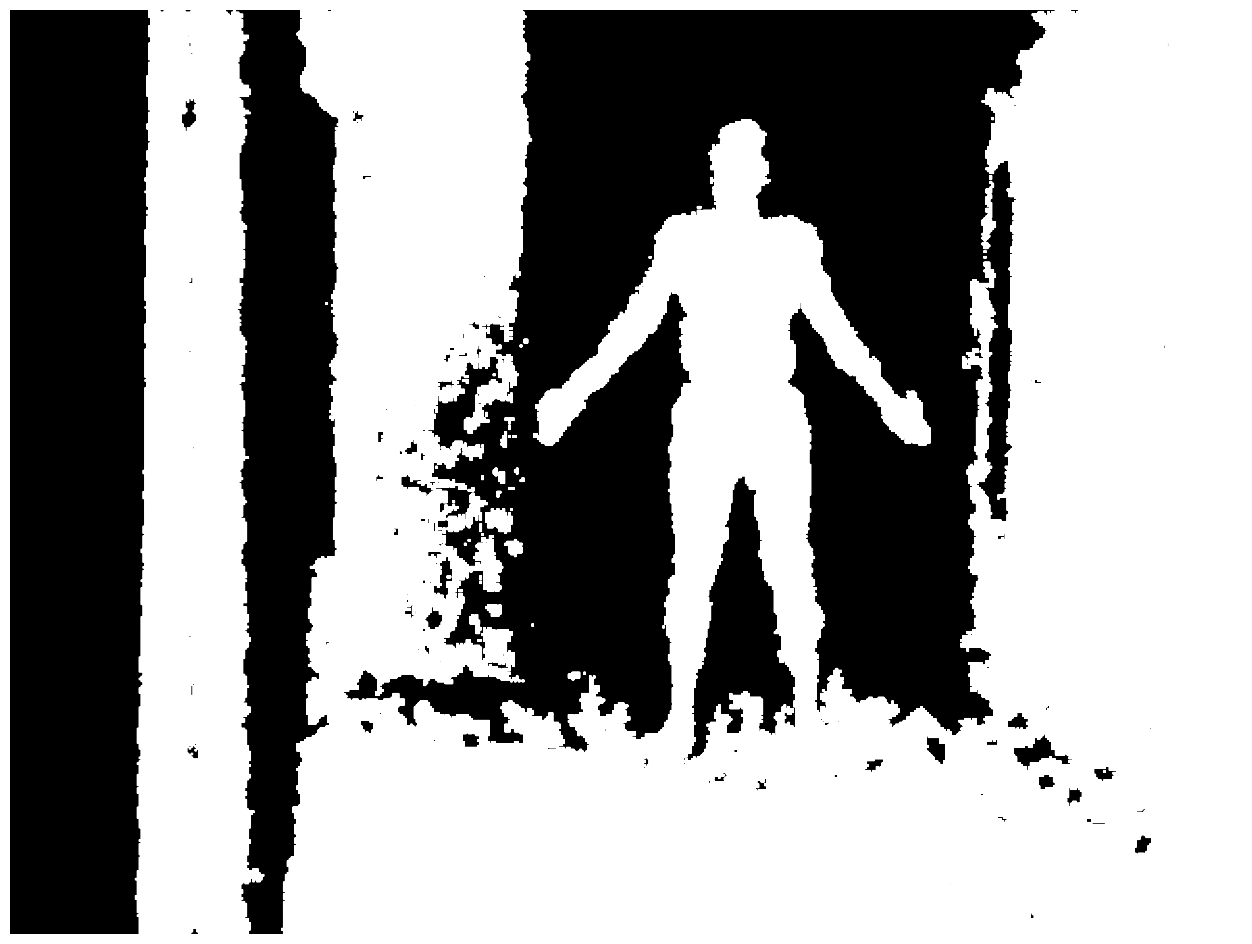

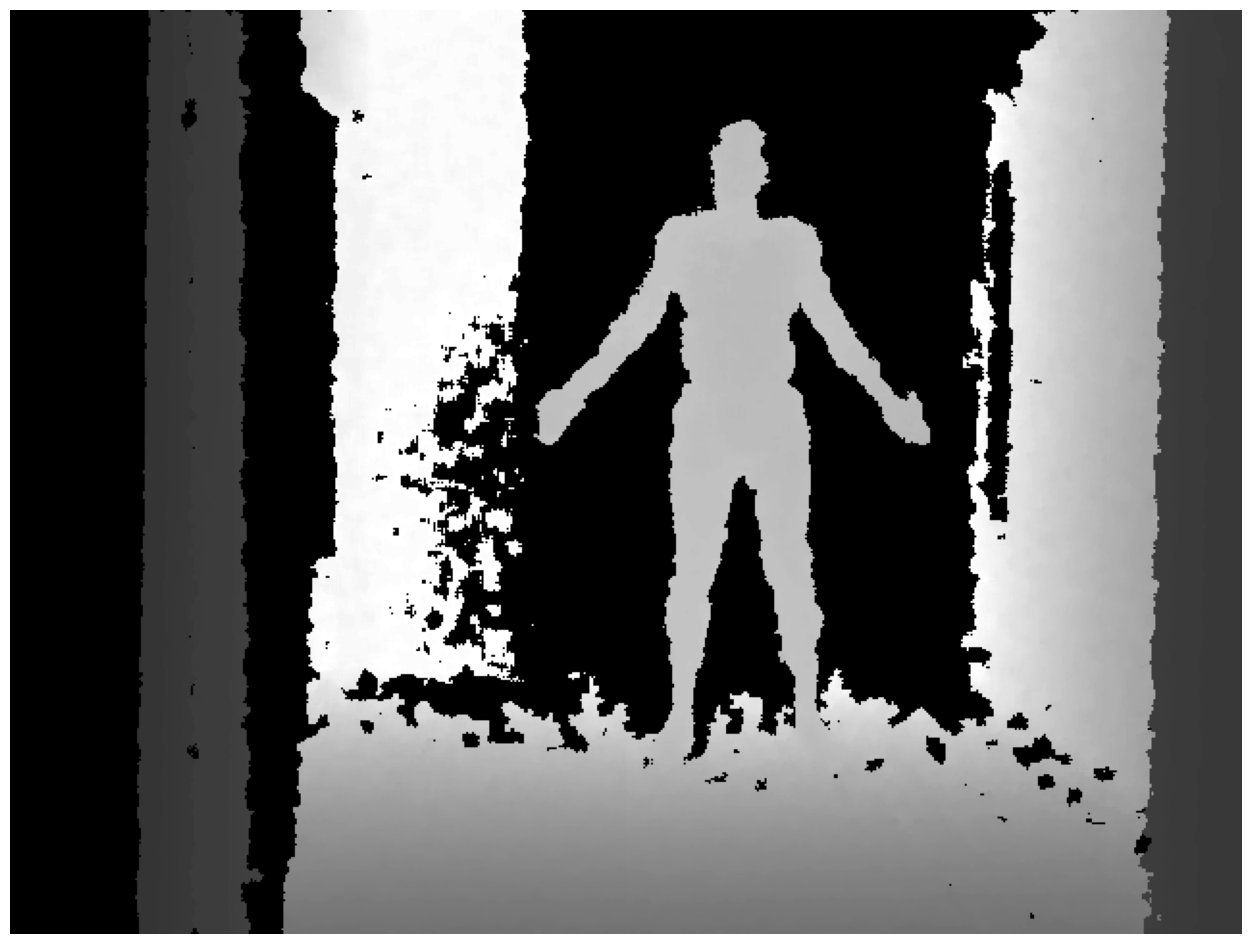

In [ ]:
# Name
name = "data/data.png"

# Image open
depth = cv2.imread(name, cv2.IMREAD_ANYDEPTH)
print(f"type of depths in depth map: {depth.dtype}")
plot_images(depth)
plot_images(normalize(depth))

# Meta data load
with open("data/data.json") as f: ###
    meta = json.load(f)

# Constant extraction
k = meta['k'] 

# Points extraction
meta.pop('k')

print(f"k = {k}")
pprint(meta)

On the second photo, the difference in brightness between the person and the objects in the background is already noticeable, whereas on the first one, the differences in brightness are not visible - everything is white. The only thing that I don't like in the second photo is that the bottom of the person's legs `merges with the floor` (they have the same distances in the depth map), which will be difficult to segment. On the other hand, as we will see later, this `will not cause any problems` for us.

Write a function that can return pairs of keys from the dictionary `meta` for skeleton points that are located next to each other.

In [ ]:
def skeleton_tuples(num=19):
    joints = list()
    joints += [["head", "shoulder_center"], ["shoulder_center", "shoulder_right"], ["shoulder_center", "shoulder_left"],
    ["shoulder_right", "elbow_right"], ["elbow_right", "wrist_right"], ["wrist_right", "hand_right"], ["shoulder_left", "elbow_left"], 
    ["elbow_left", "wrist_left"], ["wrist_left", "hand_left"], ["shoulder_center", "spine"], ["spine", "hip_center"],
    ["hip_center", "hip_right"], ["hip_center", "hip_left"], ["hip_right", "knee_right"], ["knee_right", "ankle_right"], 
    ["ankle_right", "foot_right"], ["hip_left", "knee_left"], ["knee_left", "ankle_left"], ["ankle_left", "foot_left"]]
    
    return joints[0:num]

Plot an image with all "joints" and all lines that connect joints that are located next to each other. 

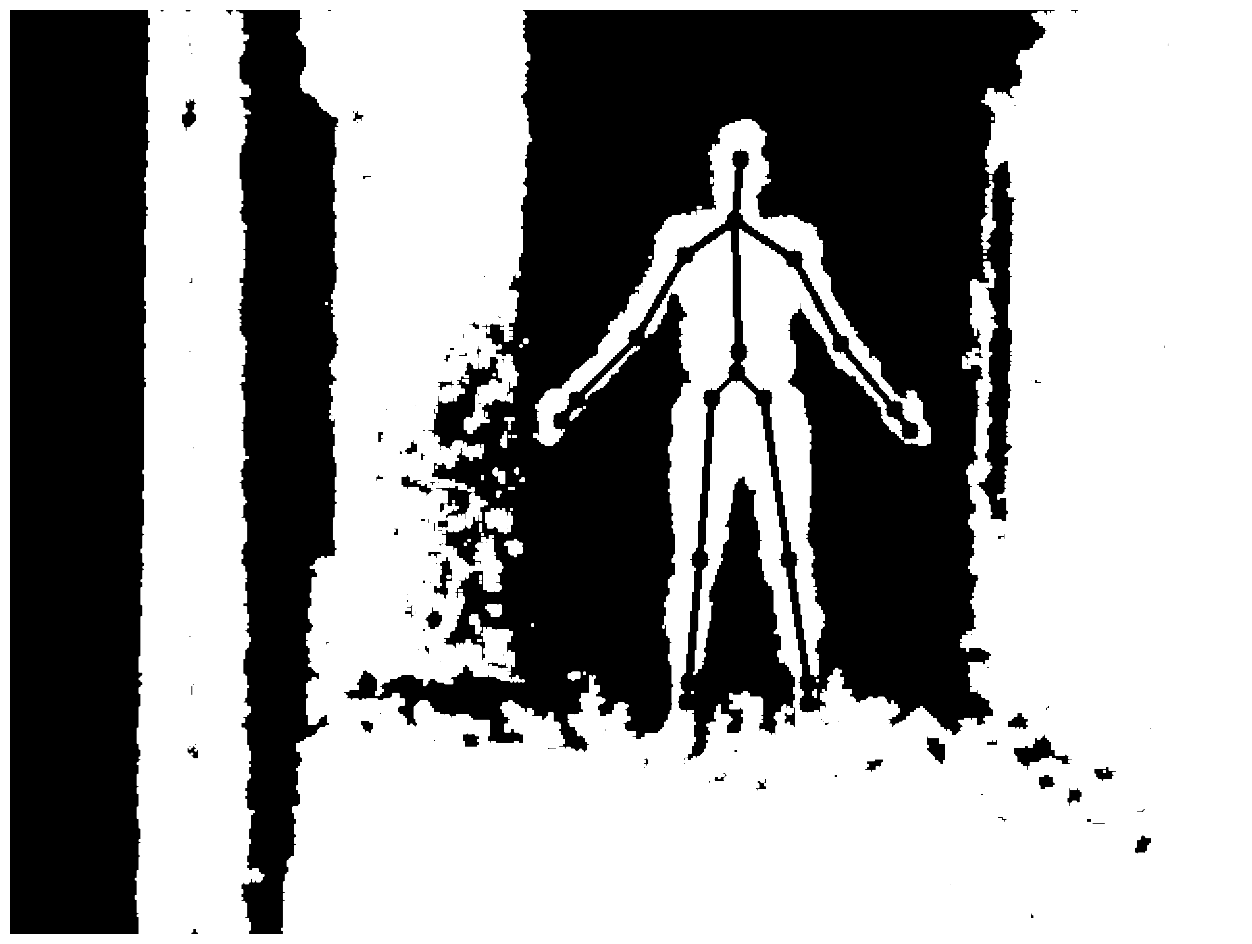

In [ ]:
depth_draw = depth.copy()

# Draw all joints as circles
for pos in meta.values():
    cv2.circle(depth_draw, pos, 5, 0, -1)

# Draw all lines
for joint_start, joint_end in skeleton_tuples():
    cv2.line(depth_draw, meta[joint_start], meta[joint_end], 0, 3)
    
plot_images(depth_draw)

To measure the height of a person more accurately, we will measure from the head to the point that is **located between the two feet** of the person. As we see in the previous images, the feet are approximately equidistant from the center of the human body, so we will take the **factor as the number 0.5**.

In [ ]:
bottom_point = point_in_distance(tuple(meta["foot_left"]), tuple(meta["foot_right"]), 0.5)
print(f"Point equidistant between left and write feet - {bottom_point}")

Point equidistant between left and write feet - (382.5, 359.5)


Measure the distance and add **1/14** of the found height as a part between the head point and the top of the head.

In [ ]:
f1 = 0

f1 = distance_cm(meta["head"], bottom_point, k)
f1 = 15 * f1 / 14

print(f"The height of the person is {f1:.2f} cm.")

The height of the person is 162.21 cm.


From the depth map, we will segment the person. We can utilize the knowledge that the measured subject, according to the measurement methodology, stood **296 cm** from the sensor. The thickness of the person is a maximum of **50 cm**. As a result, we will save the **contour of the person** since it will be useful for further analysis.

First, crop the image and recalculate the coordinates of skeleton points.

{'ankle_left': [144, 299],
 'ankle_right': [82, 299],
 'elbow_left': [161, 123],
 'elbow_right': [55, 120],
 'foot_left': [144, 310],
 'foot_right': [81, 309],
 'hand_left': [197, 168],
 'hand_right': [16, 163],
 'head': [109, 27],
 'hip_center': [107, 138],
 'hip_left': [121, 151],
 'hip_right': [94, 151],
 'knee_left': [134, 235],
 'knee_right': [88, 235],
 'shoulder_center': [106, 59],
 'shoulder_left': [137, 79],
 'shoulder_right': [80, 77],
 'spine': [108, 127],
 'wrist_left': [189, 157],
 'wrist_right': [24, 152]}


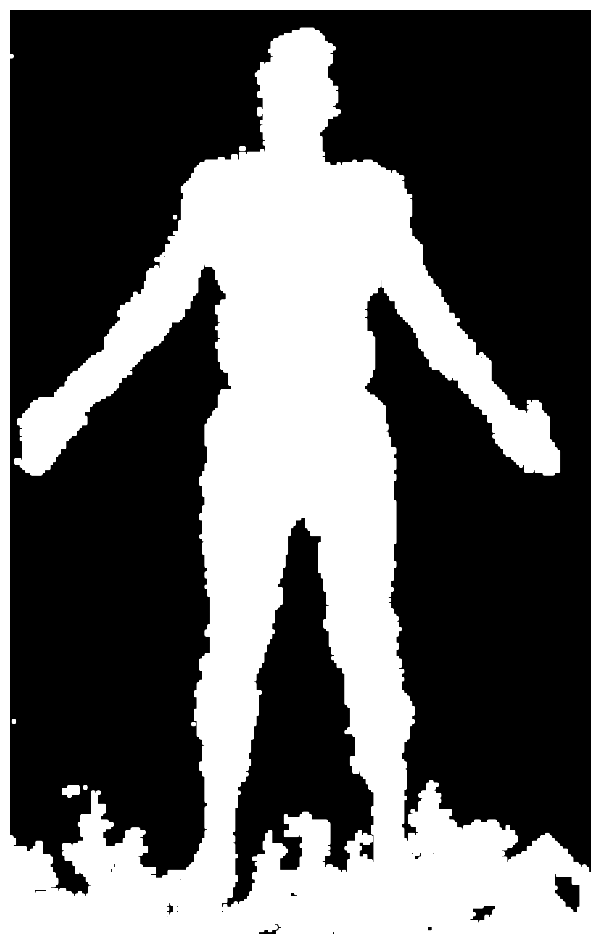

In [ ]:
image = depth.copy()

# Don't forget to recount joints while cropping!
image = crop(image, 270, 50, 490, 400)
plot_images(image)

meta_new = recount_joints(meta, (270, 50))
pprint(meta_new)

Now we will segment the person using **segmentation_two_thresholds**. We will also try to perform `erosion` and `opening`. In the end, we will choose the segmentation that we like the most. After that, we will find the contour of the segmented person.

Number of contours: 1


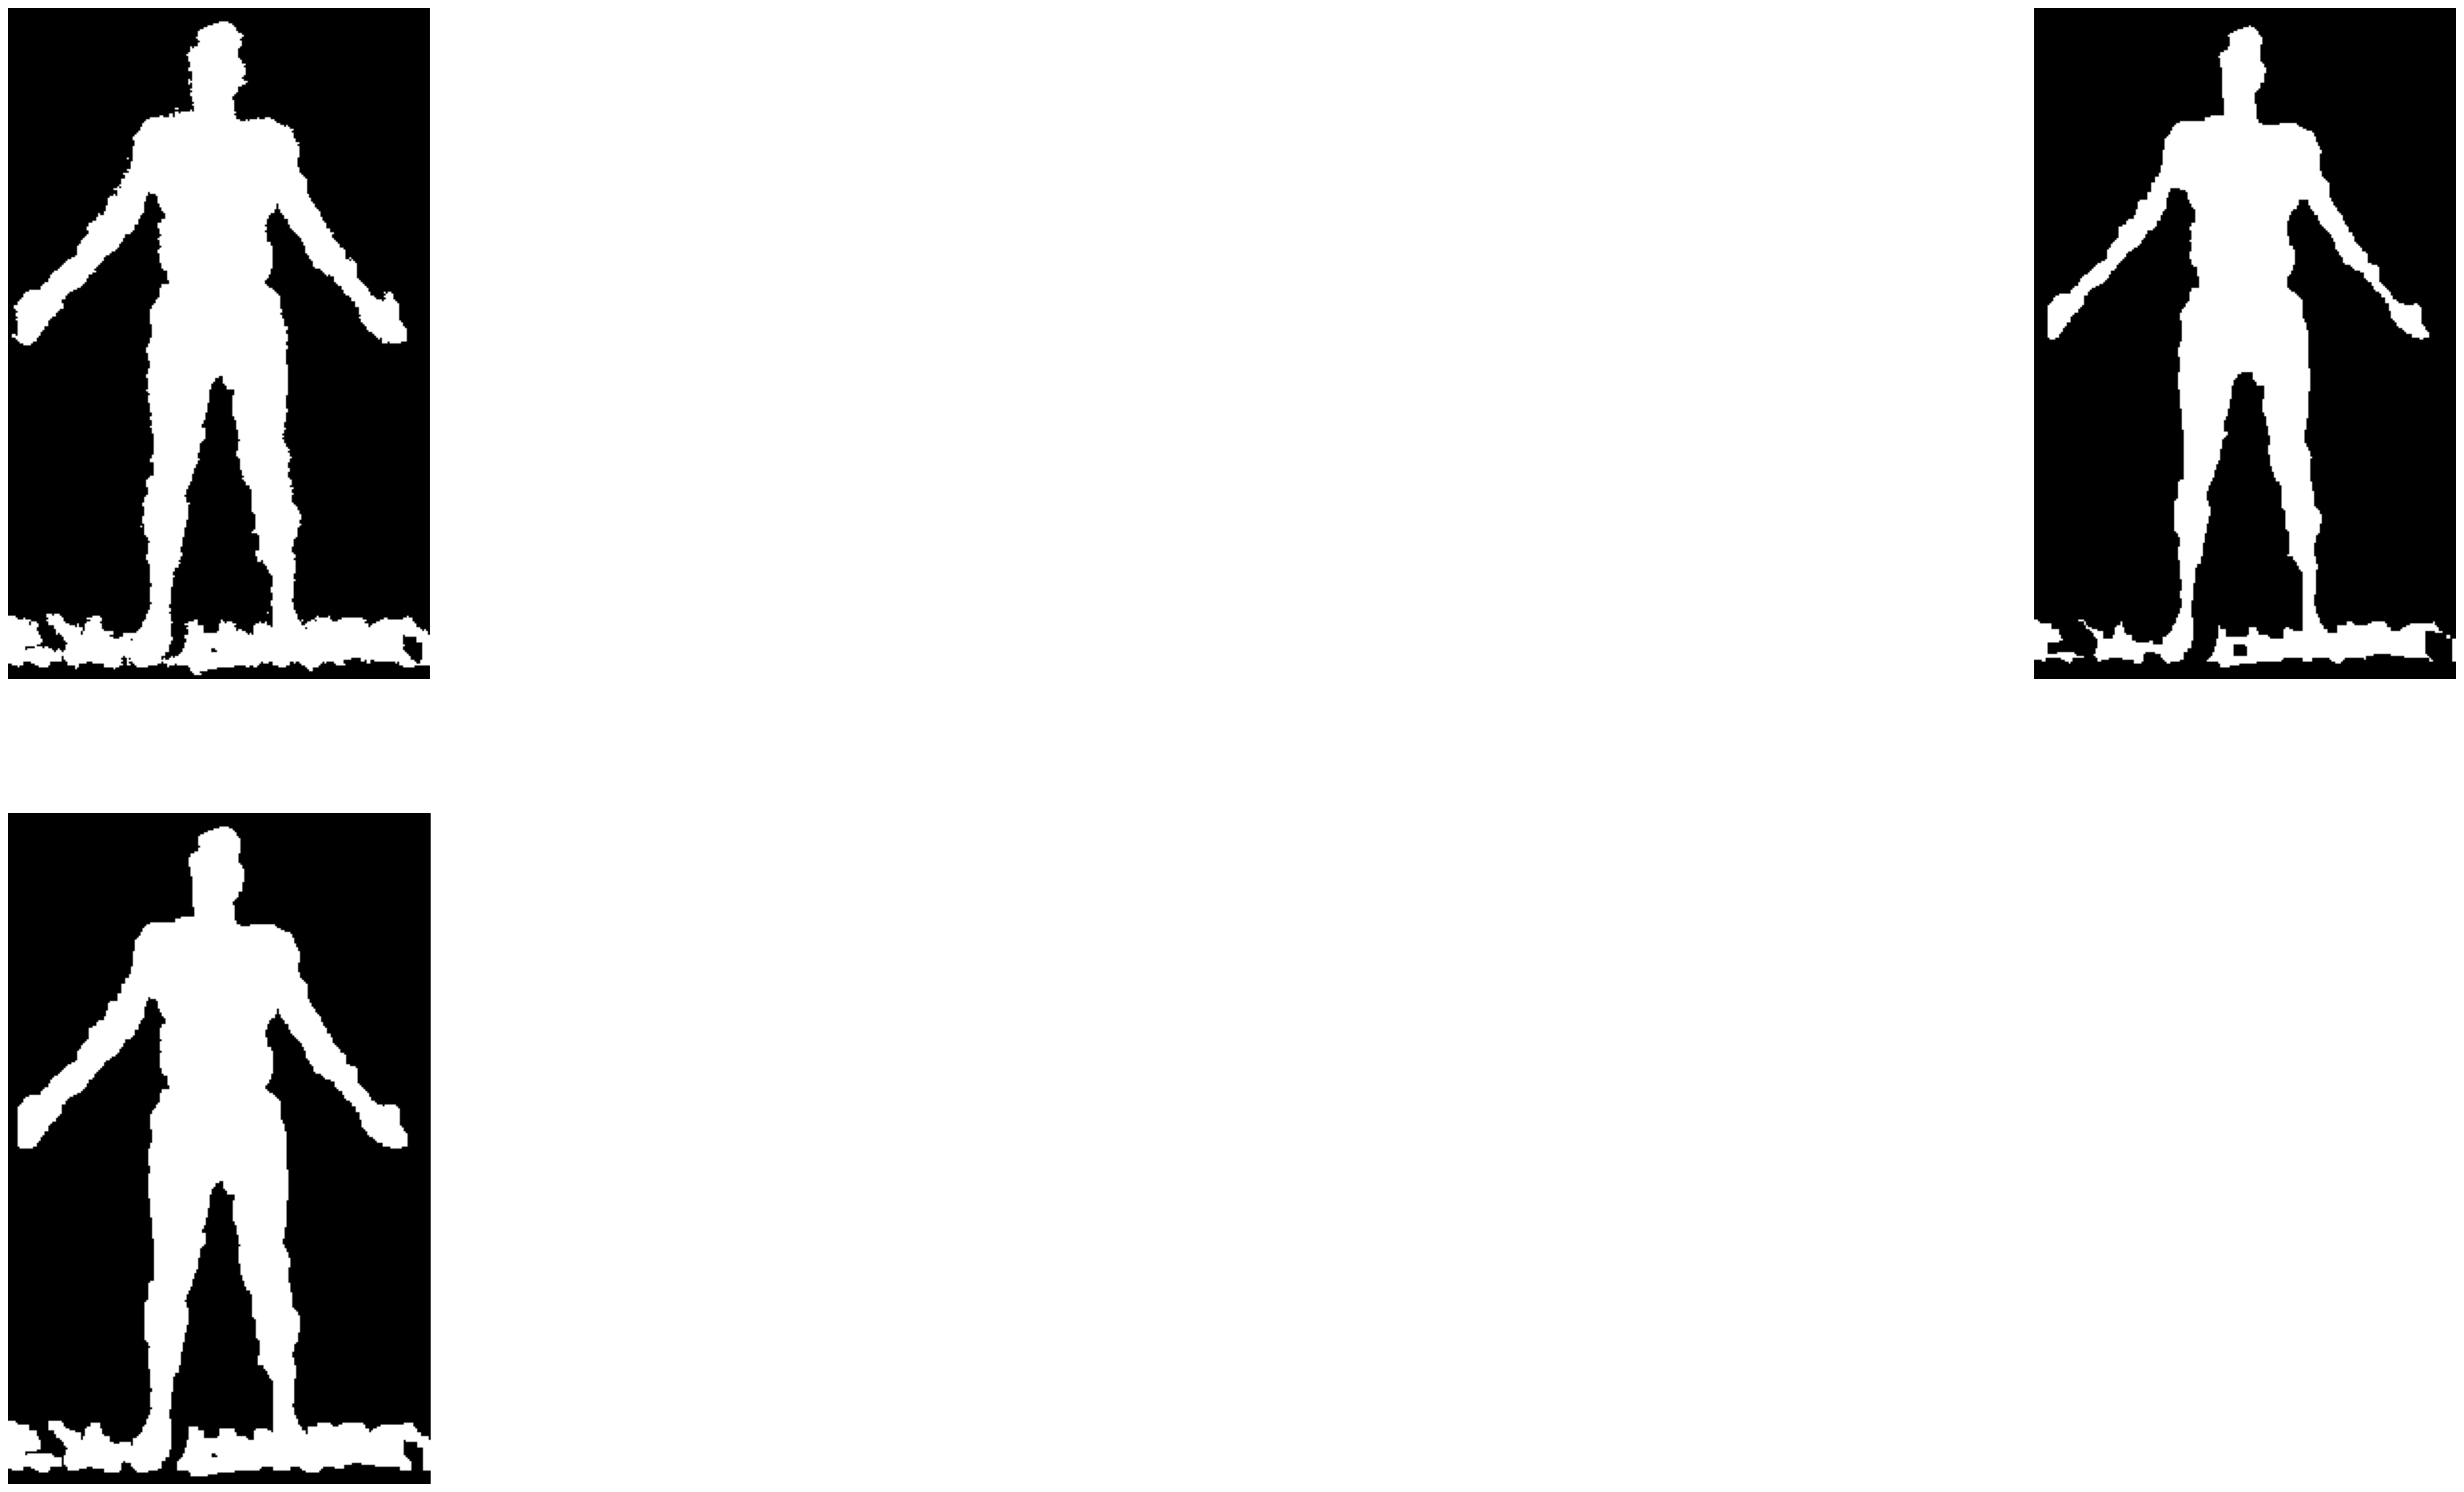

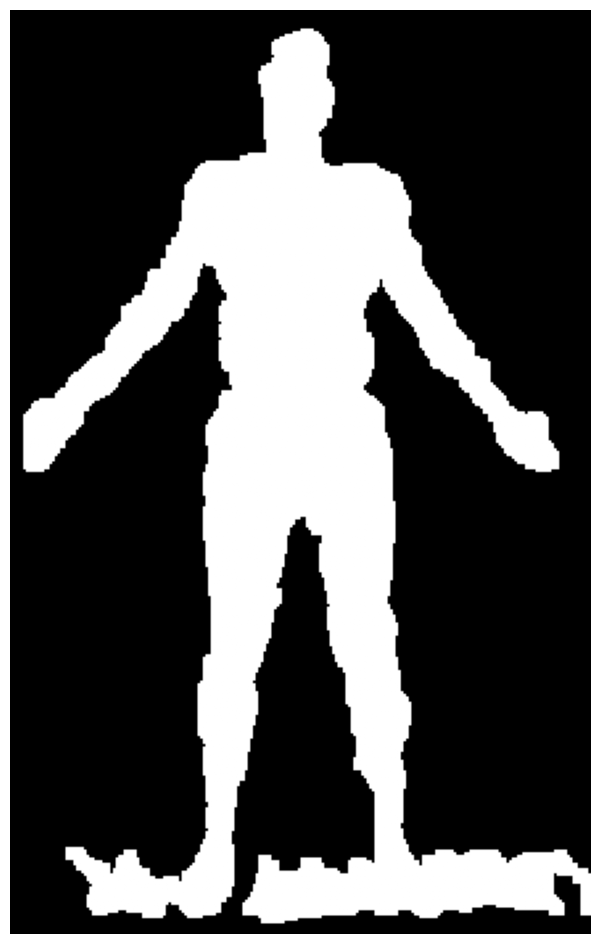

In [ ]:
# Segmentation
mask = segmentation_two_thresholds(image, 2800, 3300)

kernel = np.ones((5, 5), np.uint8)

erosion_result = cv2.erode(mask, kernel, iterations=1)

opening_result = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

plot_images(mask, erosion_result, opening_result)

# Gets one final contour in form of np.ndarray
person_mask, num_of_contours, contours = find_contours(opening_result, 10000)
plot_images(person_mask)
print(f"Number of contours: {num_of_contours}")

contour = contours[0]

As for me, the third one (one after `opening`) is the best. It has the most even contours, and even the segmentation of the right leg turned out quite well, although not perfectly. Unfortunately, it was not possible to segment the bottom of the left leg, but this will not hinder us in any way.

Now let's look at the contour of segmented person. Because the contour of the person plays an important role in the `special function`, it is important for us to ensure that it does not have holes and that we can find points on the contour that lie on the normal.

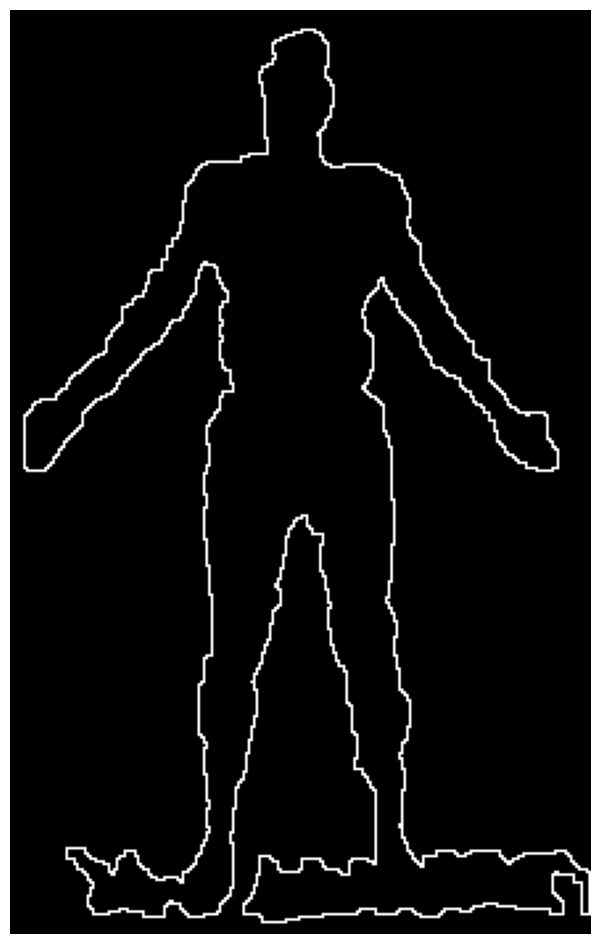

In [ ]:
plot_images(cv2.drawContours(np.zeros_like(image), contours, -1, (255,255,255), 1, cv2.LINE_4 ))

The contour appears continuous, so there should be no problems with finding the intersection point.

Measure additional required dimensions: the length of the thigh `f2` and the length of the upper arm `f4`.

To find a more accurate value for the length of the thigh and upper arm, we will find the distance on each leg and arm, respectively, and take the **arithmetic mean value** from them.

In [ ]:
f2 = (distance_cm(meta["hip_left"], meta["knee_left"], k) + distance_cm(meta["hip_right"], meta["knee_right"], k)) / 2
f4 = (distance_cm(meta["shoulder_left"], meta["elbow_left"], k) + distance_cm(meta["shoulder_right"], meta["elbow_right"], k)) / 2

print(f"The thigh length of the person is {f2:.2f} cm.")
print(f"The length of the upper arm of the person is {f4:.2f} cm.")

The thigh length of the person is 45.34 cm.
The length of the upper arm of the person is 26.76 cm.


Let's find the positions of points for measuring the width of the person's contour `p_3`, `p_5`, `p_7`, and `p_6`.
- The point for measuring the **calf** is located at 2/3 of the length between the skeleton points `knee` and `ankle`.
- The point for measuring the **arm** is located at 2/3 of the length between the skeleton points `shoulder` and `elbow`.
- The point for measuring the **thigh** is located at 4/5 of the length between the skeleton points `hip` and `knee`.
- The point for measuring the **waist** is located at the skeleton point `hip_center`.

Next, let's find two contour points that lie on the normal (= perpendicular line) to the line connecting the aforementioned skeleton points and measure the distances between them `d3`, `d5`, and `d7`.

For the distance `d6`, the line connecting the skeleton point `shoulder_center` with the point `hip_center` will be used.

Find the positions of points for measuring the width of contours of different body parts. We will use a `helper function` to find **2 contour points** lying on the normal to the line connecting the above skeleton points, and measure the distances between them.

In [ ]:
p_3 = tuple_elems_to_int(point_in_distance(tuple(meta_new["knee_left"]), tuple(meta_new["ankle_left"]), 2/3))
p_5 = tuple_elems_to_int(point_in_distance(tuple(meta_new["shoulder_left"]), tuple(meta_new["elbow_left"]), 2/3))
p_7 = tuple_elems_to_int(point_in_distance(tuple(meta_new["hip_left"]), tuple(meta_new["knee_left"]), 4/5))
p_6 = tuple(meta_new["hip_center"])

points = [p_3, p_5, p_7, p_6]

print(points)

[(140, 277), (153, 108), (131, 218), (107, 138)]


10.237973024773996 8.640805364316453 13.03852313894484 28.40164


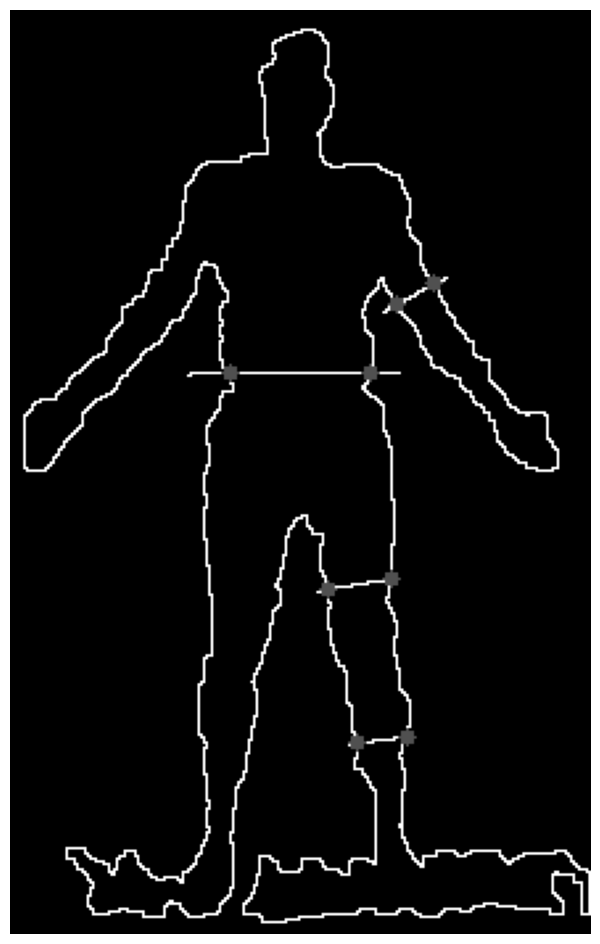

In [ ]:
measured_joint_pairs = [
    [ tuple(meta_new["knee_left"]), tuple(meta_new["ankle_left"]) ],
    [ tuple(meta_new["shoulder_left"]), tuple(meta_new["elbow_left"]) ],
    [ tuple(meta_new["hip_left"]), tuple(meta_new["knee_left"]) ],
    [ tuple(meta_new["shoulder_center"]), tuple(meta_new["hip_center"]) ]
]

d3, d5, d7, d6 = measure_distances_using_impro(image, contours, points, measured_joint_pairs)
print(d3, d5, d7, d6)

Assuming that the calf, arm, and thigh can be approximated by a geometric shape of a cylinder, we obtained distances from the person's contour at the required points from the image. Then, the calculation of the perimeters `f3`, `f5`, and `f7` can be obtained using the following formula:

$$
f_i = \pi \cdot d_i$, for $i \in \{3, 5, 7\}
$$

Calculate the circumference of the calf, upper arm and thigh, respectively.

In [ ]:
f3 = np.pi * d3
f5 = np.pi * d5
f7 = np.pi * d7


print(f"The circumference of the calf of the person is {f3:.2f} cm.")
print(f"The circumference of the upper arm of the person is {f5:.2f} cm.")
print(f"The circumference of the thigh of the person is {f7:.2f} cm.")

The circumference of the calf of the person is 32.16 cm.
The circumference of the upper arm of the person is 27.15 cm.
The circumference of the thigh of the person is 40.96 cm.


Assume that the waist cannot be entirely approximated by a cylinder. We will take this dimension as one boundary. As the second boundary dimension, we will take twice the dimension `d6`. Their average will then be used to calculate the waist circumference according to the formula:

$$
f_6 = \frac{\pi \cdot d_6 + 2 \cdot d_6}{2}
$$

Calculate the circumference of the waist.

In [ ]:
f6 = (np.pi * d6 + 2 * d6) / 2

print(f"The circumference of the waist of the person is {f6:.2f} cm.")

The circumference of the waist of the person is 73.01 cm.


Let's calculate the estimated weight.

According to [1], the estimated weight of a person in kilograms can be calculated using the following formula.

$$
m = -122,27 + 0,48 \cdot f_1 - 0,17 \cdot f_2 + 0,52 \cdot f_3 + 0,16 \cdot f_4 + 0,77 \cdot f_5 + 0,49 \cdot f6 + 0,58 \cdot f_7
$$

Calculate the **estimated weight** of a person in kilograms.

In [ ]:
m = -122.27 + 0.48 * f1 - 0.17 * f2 + 0.52 * f3 + 0.16 * f4 + 0.77 * f5 + 0.49 * f6 + 0.58 * f7 

print(f"The estimated weight of the person is {m:.2f} kg.")

The estimated weight of the person is 49.33 kg.


Calculate **BMI** from the standard relationship as the ratio of weight $m$ in kilograms to height $h$ in meters of the person.

$$
BMI = \frac{m}{h^2}
$$

Calculate **BMI** as the ratio of weight (m in kg) to square of the height (h² in m²) of a person.

In [ ]:
BMI = m / (f1 / 100)**2

print(f"The resulting BMI is {BMI:.2f} kg/m².")

The resulting BMI is 18.75 kg/m².


According to the wikipedia, person is in normal range. My congratulations!!!

![bmi_from_wiki](images/bmi_from_wiki.png)

That's all!